# Abstract

This notebook compares the candidate mechanism perturbation amplitude at multiple disease stages in Alzheimer's Disease experiments, using the PyBEL web service

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from pandas.plotting import andrews_curves, parallel_coordinates
from sklearn.cluster import KMeans
from sklearn import preprocessing
import time

In [2]:
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
np.random.seed(5)

In [4]:
time.asctime()

'Mon Feb 26 16:33:56 2018'

In [5]:
downloads = os.path.join(os.path.expanduser("~"), "Downloads")

early = os.path.join(downloads, "1.csv")
moderate = os.path.join(downloads, "2.csv")
severe = os.path.join(downloads, "3.csv")

In [6]:
scaler = preprocessing.StandardScaler()

In [7]:
early_df = pd.read_csv(early).rename(index=str, columns={"avg": "EarlyAvg"})
moderate_df = pd.read_csv(moderate).rename(index=str, columns={"avg": "ModerateAvg"})
severe_df = pd.read_csv(severe).rename(index=str, columns={"avg": "SevereAvg"})

df = pd.concat(
    [
        early_df[["Namespace", "Name", "EarlyAvg"]],
        moderate_df["ModerateAvg"],
        severe_df["SevereAvg"],
    ],
    axis=1,
)

df = df[df["EarlyAvg"].notnull()]
df = df[df["EarlyAvg"] != 0]

cols = ["EarlyAvg", "ModerateAvg", "SevereAvg"]

df.to_csv(os.path.join(os.path.expanduser("~"), "Desktop", "time_series_cmpa.csv"))
df.head()

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg
1,GOBP,response to oxidative stress,11.922756,6.904458,0.818689
3,GOBP,mitochondrial calcium ion homeostasis,-10.220753,-2.898852,-2.534374
4,GOBP,electron transport chain,-10.220753,-2.898852,-2.534374
5,GOBP,calcium ion homeostasis,2.326490,10.082439,6.821336
6,GOBP,microglial cell activation involved in immune ...,0.276019,-4.376121,-2.382717


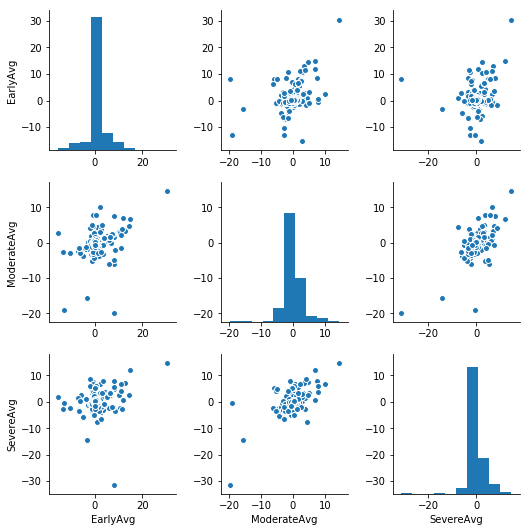

In [8]:
sns.pairplot(df[["EarlyAvg", "ModerateAvg", "SevereAvg"]])
plt.show()

Use the pearson correlation over the time series

In [9]:
corr_df = df[cols].T.corr()

Clustering reveals 3 general patterns of biological processes throughout the progressions.

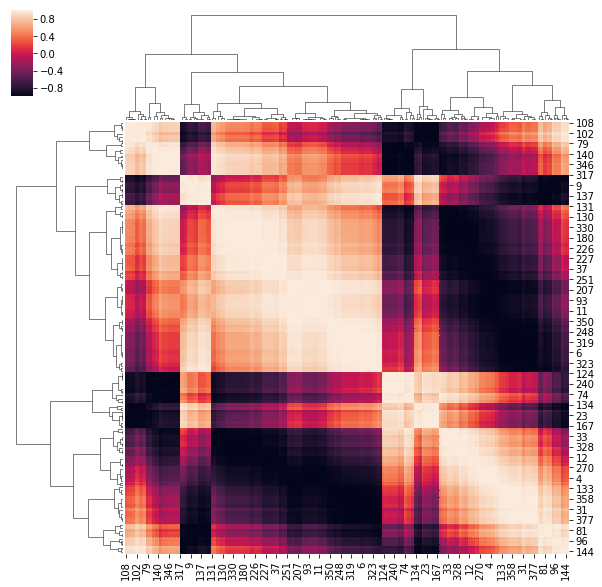

In [10]:
cg = sns.clustermap(corr_df)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig(
    os.path.join(os.path.expanduser("~"), "Desktop", "time_series_clustering_ad.pdf")
)
plt.show()

Assign classes based on a simple k-means clustering.

In [11]:
km = KMeans(n_clusters=5)
km.fit(df[cols])

df["label"] = km.labels_

Parallel coordinates immediately reveal the groups of patterns in relation of each mechanism to the disease progressions. Andrews curves use fourier analysis to reveal further patterns in the frequency domain.

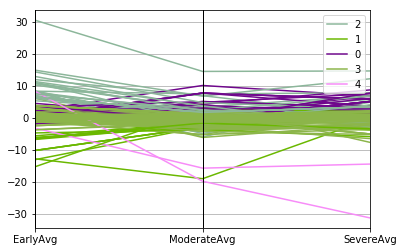

In [12]:
parallel_coordinates(df[["EarlyAvg", "ModerateAvg", "SevereAvg", "label"]], "label")
plt.savefig(os.path.join(os.path.expanduser("~"), "Desktop", "time_series_pc.pdf"))

Retry the whole analysis but min/max normalize each column first

In [13]:
df_norm = df[cols].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

norm_corr_df = df_norm[cols].T.corr()

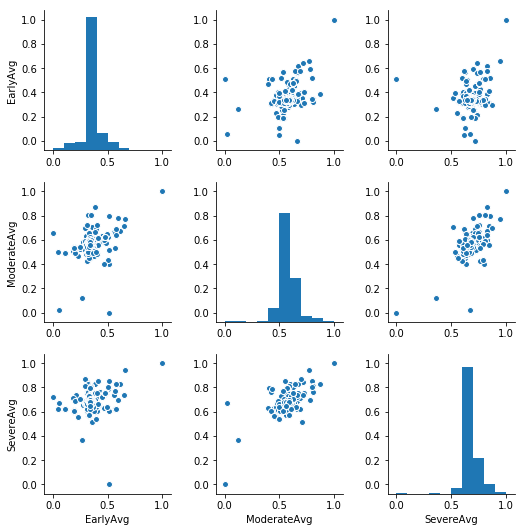

In [14]:
sns.pairplot(df_norm[["EarlyAvg", "ModerateAvg", "SevereAvg"]])
plt.show()

In [16]:
# cg = sns.clustermap(norm_corr_df)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()

In [17]:
km_norm = KMeans(n_clusters=6)
km_norm.fit(df[cols])

df_norm["label"] = km_norm.labels_

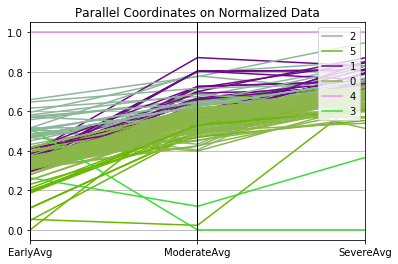

In [18]:
plt.title("Parallel Coordinates on Normalized Data")
parallel_coordinates(df_norm, "label")
plt.show()

Class `0` contains candidate mechanisms whose CMPA scores are neither significant nor do they change much over time. The other class members are enumerated below.

In [19]:
df[df["label"] == 0]

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg,label
5,GOBP,calcium ion homeostasis,2.326490,10.082439,6.821336,0
12,GOBP,memory,-0.808335,4.813867,7.480508,0
43,GOBP,cell proliferation,0.896167,2.478145,1.950688,0
45,GOBP,Notch signaling pathway,-1.822177,4.178887,8.694139,0
57,GOBP,calcium ion import,4.482384,0.409248,3.796884,0
64,GOBP,zinc ion homeostasis,0.248634,-0.319183,5.076812,0
68,GOBP,generation of neurons,0.564985,7.706614,5.794660,0
74,GOBP,glucose metabolic process,-0.608376,0.656481,6.756742,0
78,GOBP,regulation of synaptic plasticity,-1.059119,5.082835,3.217849,0
96,GOBP,chemokine biosynthetic process,1.645633,2.851218,1.701339,0


In [20]:
df[df["label"] == 1]

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg,label
3,GOBP,mitochondrial calcium ion homeostasis,-10.220753,-2.898852,-2.534374,1
4,GOBP,electron transport chain,-10.220753,-2.898852,-2.534374,1
13,GOBP,"regulation of synaptic transmission, cholinergic",-6.319755,-1.844384,-3.837040,1
22,GOBP,cognition,-13.098864,-2.769259,-2.702428,1
33,GOBP,mitochondria-nucleus signaling pathway,-5.657756,-1.472886,2.661210,1
34,GOBP,mitochondrion organization,-6.785946,-2.283427,1.524850,1
35,GOBP,mitochondrial transport,-6.450751,-1.657418,-3.457478,1
36,GOBP,protein import into mitochondrial matrix,-10.220753,-2.898852,-2.534374,1
60,GOBP,reelin-mediated signaling pathway,-6.596265,-1.350615,-3.165148,1
67,GOBP,positive regulation of neuron apoptotic process,-12.844473,-19.054702,-0.414471,1


In [21]:
df[df["label"] == 2]

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg,label
1,GOBP,response to oxidative stress,11.922756,6.904458,0.818689,2
7,GOBP,inflammatory response,8.303427,7.448499,7.812735,2
8,GOBP,reactive oxygen species metabolic process,10.220753,2.898852,2.534374,2
9,GOBP,neuron apoptotic process,8.260572,-5.967573,5.291992,2
11,GOBP,cell death,30.477614,14.481597,14.626048,2
19,MESHPP,Lipid Peroxidation,12.901503,3.314835,6.914957,2
32,GOBP,response to reactive oxygen species,6.450751,1.657418,3.457478,2
54,GOBP,ERK1 and ERK2 cascade,6.273226,0.171814,2.436955,2
62,GOBP,negative regulation of calcium-mediated signaling,7.957573,-4.954710,4.877306,2
77,GOBP,neuron projection development,10.665303,2.719991,-2.536432,2


In [22]:
df[df["label"] == 3]

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg,label
6,GOBP,microglial cell activation involved in immune ...,0.276019,-4.376121,-2.382717,3
10,GOBP,apoptotic process,1.056038,4.296424,-7.694186,3
14,GOBP,neuronal signal transduction,-1.066868,-2.614872,-2.639730,3
15,GOBP,response to endoplasmic reticulum stress,-0.730211,-0.553103,-5.064365,3
16,GOBP,response to unfolded protein,1.567032,0.929631,-0.787240,3
17,GOBP,endoplasmic reticulum calcium ion homeostasis,1.761505,2.375824,1.026676,3
18,GOBP,regulation of ryanodine-sensitive calcium-rele...,-3.740118,-1.692425,1.193665,3
21,GOBP,cholesterol homeostasis,0.536060,0.432731,1.045690,3
23,GOBP,neuron death,-1.181309,-5.315558,3.885110,3
24,GOBP,positive regulation of glial cell apoptotic pr...,1.372896,-2.790113,-1.101693,3


In [23]:
df[df["label"] == 4]

,Namespace,Name,EarlyAvg,ModerateAvg,SevereAvg,label
98,GOBP,production of molecular mediator involved in i...,-3.234381,-15.750005,-14.480265,4
340,GOBP,glial cell differentiation,8.239913,-19.845326,-31.309422,4


# Conclusions

Patients can be measured at multiple time points to be temporally aligned based on these patterns and possibly identify a disease subtype.